In [5]:
!pip install datasets langchain_community faiss-cpu optimum-quanto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 32.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [2]:
from tqdm import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [4]:
from datasets import load_dataset

df = load_dataset(path="MedRAG/textbooks", split="train")

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

In [5]:
df = df.to_pandas()

In [6]:
df['text'] = "title: "+ df['title'] + "\n" +df['content'] + " " + df['contents']
df.head()

,id,title,content,contents,text
0,Anatomy_Gray_0,Anatomy_Gray,What is anatomy? Anatomy includes those struct...,Anatomy_Gray. What is anatomy? Anatomy include...,title: Anatomy_Gray\nWhat is anatomy? Anatomy ...
1,Anatomy_Gray_1,Anatomy_Gray,Observation and visualization are the primary ...,Anatomy_Gray. Observation and visualization ar...,title: Anatomy_Gray\nObservation and visualiza...
2,Anatomy_Gray_2,Anatomy_Gray,How can gross anatomy be studied? The term ana...,Anatomy_Gray. How can gross anatomy be studied...,title: Anatomy_Gray\nHow can gross anatomy be ...
3,Anatomy_Gray_3,Anatomy_Gray,"This includes the vasculature, the nerves, the...","Anatomy_Gray. This includes the vasculature, t...",title: Anatomy_Gray\nThis includes the vascula...
4,Anatomy_Gray_4,Anatomy_Gray,Each of these approaches has benefits and defi...,Anatomy_Gray. Each of these approaches has ben...,title: Anatomy_Gray\nEach of these approaches ...


In [7]:
df = df[:500]

In [8]:
from langchain.docstore.document import Document

RAG_KNOWLEDGE_BASE = [
    Document(page_content=row['text'])
    for index, row in tqdm(df.iterrows())
]

500it [00:00, 13864.18it/s]


In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

MARKDOWN_SEPARATOR = [
    "\n#{1, 6}",
    "'''\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    ""
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,      #max no. of chars in a chunk
    chunk_overlap = 100,    #no. of chars to overlap between chunks
    add_start_index = True,  #if "true", includes chunk's start index in metadata
    strip_whitespace = True,  #removes whitespaces from start and end of every document
    separators = MARKDOWN_SEPARATOR
)

In [10]:
docs_processed = []
for doc in RAG_KNOWLEDGE_BASE:
  docs_processed.extend(text_splitter.split_documents([doc]))
len(docs_processed), docs_processed[0]

(1561,
 Document(metadata={'start_index': 0}, page_content='title: Anatomy_Gray'))

In [11]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("thenlper/gte-small")
print(f"Model max seq len: {model.max_seq_length}")

Model max seq len: 512


In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")  #gte- general text embedding
lenghts = [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]
print("Max length :", max(lenghts))

Max length : 404


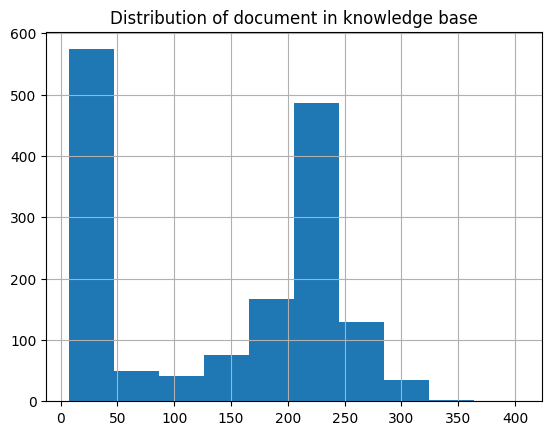

In [13]:
fig = pd.Series(lenghts).hist()
plt.title("Distribution of document in knowledge base")
plt.show()

# proper chunking

In [14]:
def split_documents(chunk_size, knowledge_base, tokenizer_name, MARKDOWN_SEPARATOR):

  text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
      AutoTokenizer.from_pretrained(tokenizer_name),
      chunk_size = chunk_size,
      chunk_overlap = int(chunk_size)//10,
      add_start_index = True,
      strip_whitespace = True,
      separators = MARKDOWN_SEPARATOR
  )

  docs_processed = []
  for doc in knowledge_base:
    docs_processed.extend(text_splitter.split_documents([doc]))

  #remove duplicates
  unique_texts = {}
  unique_docs = []
  for doc in docs_processed:
    if doc.page_content not in unique_texts:
      unique_texts[doc.page_content] = True
      unique_docs.append(doc)


  return unique_texts, unique_docs

tokenizer_name = "thenlper/gte-small"
dic, docs = split_documents(model.max_seq_length, RAG_KNOWLEDGE_BASE, tokenizer_name, MARKDOWN_SEPARATOR)

In [15]:
print(abs(len(docs)-len(docs_processed)))

993


In [16]:
print(dic, docs)

{'title: Anatomy_Gray\nWhat is anatomy? Anatomy includes those structures that can be seen grossly (without the aid of magnification) and microscopically (with the aid of magnification). Typically, when used by itself, the term anatomy tends to mean gross or macroscopic anatomy—that is, the study of structures that can be seen without using a microscopic. Microscopic anatomy, also called histology, is the study of cells and tissues using a microscope. Anatomy forms the basis for the practice of medicine. Anatomy leads the physician toward an understanding of a patient’s disease, whether he or she is carrying out a physical examination or using the most advanced imaging techniques. Anatomy is also important for dentists, chiropractors, physical therapists, and all others involved in any aspect of patient treatment that begins with an analysis of clinical signs. The ability to interpret a clinical observation correctly is therefore the endpoint of a sound anatomical understanding. Anatom

In [ ]:
print(list(docs[0]))

[('id', None), ('metadata', {'start_index': 0}), ('page_content', 'title: Anatomy_Gray\nWhat is anatomy? Anatomy includes those structures that can be seen grossly (without the aid of magnification) and microscopically (with the aid of magnification). Typically, when used by itself, the term anatomy tends to mean gross or macroscopic anatomy—that is, the study of structures that can be seen without using a microscopic. Microscopic anatomy, also called histology, is the study of cells and tissues using a microscope. Anatomy forms the basis for the practice of medicine. Anatomy leads the physician toward an understanding of a patient’s disease, whether he or she is carrying out a physical examination or using the most advanced imaging techniques. Anatomy is also important for dentists, chiropractors, physical therapists, and all others involved in any aspect of patient treatment that begins with an analysis of clinical signs. The ability to interpret a clinical observation correctly is t

In [17]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=tokenizer_name,
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}   # set True for cosine similarity
)

<ipython-input-17-5a3e0b8b37dc>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [18]:
vector_db = FAISS.from_documents(
    documents=docs,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.COSINE
)

In [19]:
user_query = "what is anatomy?"

retrieved_docs = vector_db.similarity_search(user_query, k=1)
print(
    "======================Top Documents==========================="
)
print(retrieved_docs[0].page_content)

======================Top Documents===========================
title: Anatomy_Gray
What is anatomy? Anatomy includes those structures that can be seen grossly (without the aid of magnification) and microscopically (with the aid of magnification). Typically, when used by itself, the term anatomy tends to mean gross or macroscopic anatomy—that is, the study of structures that can be seen without using a microscopic. Microscopic anatomy, also called histology, is the study of cells and tissues using a microscope. Anatomy forms the basis for the practice of medicine. Anatomy leads the physician toward an understanding of a patient’s disease, whether he or she is carrying out a physical examination or using the most advanced imaging techniques. Anatomy is also important for dentists, chiropractors, physical therapists, and all others involved in any aspect of patient treatment that begins with an analysis of clinical signs. The ability to interpret a clinical observation correctly is theref

In [27]:
!pip install -U bitsandbytes

In [27]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

BASE_MODEL = "gpt2"
model_LM = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer_LM = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer_LM.pad_token = tokenizer_LM.eos_token

PIPELINE = pipeline(
    model=model_LM,
    tokenizer=tokenizer_LM,
    task="text-generation",
    do_sample=True,
    max_new_tokens=200,
    temperature=0.7,
    repetition_penalty=1.1,
    return_full_text=False
)

def chat_prompt_template(context, question):
    return f"""
    <|system|>: You are a helpful assistant.
    Using the information contained in the provided context, give a comprehensive answer to the question.
    Respond with both the question asked and any relevant knowledge you have.
    If the answer cannot be deduced from the context, clearly state that.</s>

    <|user|>
    Context:
    {context}
    -----
    Question:
    {question}</s>
    <|assistant|>
    """

user_query = "what is anatomy?"


retrieved_docs = [
    {"page_content": "Anatomy includes structures seen grossly (without magnification) and microscopically (with magnification)."}
]

context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {i}:::\n{doc['page_content']}\n" for i, doc in enumerate(retrieved_docs)]
)

question = user_query
prompt = chat_prompt_template(context, question)
print(prompt)

try:
    response = PIPELINE(prompt)[0]['generated_text']
    print("\nResponse:\n", response)
except RuntimeError as e:
    print(f"CUDA Error: {e}")


Device set to use cpu



    <|system|>: You are a helpful assistant.
    Using the information contained in the provided context, give a comprehensive answer to the question.
    Respond with both the question asked and any relevant knowledge you have.
    If the answer cannot be deduced from the context, clearly state that.</s>

    <|user|>
    Context:
    
Extracted documents:
Document 0:::
Anatomy includes structures seen grossly (without magnification) and microscopically (with magnification).

    -----
    Question:
    what is anatomy?</s>
    <|assistant|>
    

Response:
  Categories of objects on which anatomical descriptions can apply; generally physical or mental/psychological features such as bones & teeth must also occur.<br /> The "thing" may include things like body parts for example-a human being(e.g., head), etc.[2] However, once it has been noted how large an object was there will always require further observation due to various factors including size[3]. Thus even if this description d